In [1]:
%pip install langgraph

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install graphviz pygraphviz

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Failed to build pygraphviz
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Building wheel for pygraphviz (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [88 lines of output]
      C:\Users\kimzi\AppData\Local\Temp\pip-build-env-2wntcmpc\overlay\Lib\site-packages\setuptools\config\_apply_pyprojecttoml.py:82: SetuptoolsDeprecationWarning: `project.license` as a TOML table is deprecated
      !!
      
              ********************************************************************************
              Please use a simple string containing a SPDX expression for `project.license`. You can also use `project.license-files`. (Both options available on setuptools>=77.0.0).
      
              By 2026-Feb-18, you need to update your project and remove deprecated calls
              or your builds will no longer be supported.
      
              See https://packaging.python.org/en/latest/guides/writing-pyproject-toml/#license for details.
              **********************************************

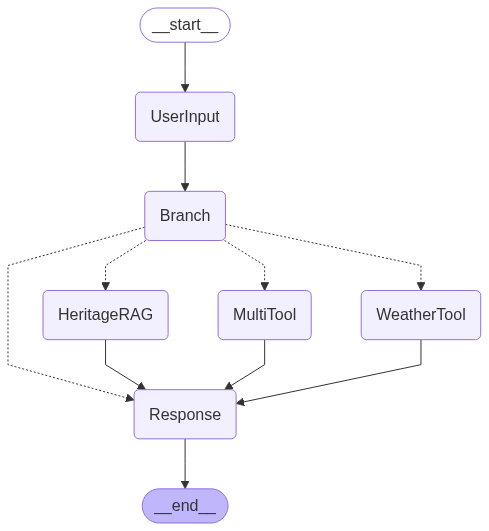

In [ ]:
from typing import TypedDict, Optional
from langgraph.graph import StateGraph, START, END

# 1. 상태 스키마 정의
class MyState(TypedDict):
    query: str
    next_node: Optional[str]  # 분기 결과 저장 필드 추가
    result: Optional[str]
    answer: Optional[str]

# 2. 각 노드 함수 정의 (수정 버전)
def user_input_node(state: MyState):
    return {"query": state["query"]}

def branch_node(state: MyState):
    query = state["query"]
    # 상태 업데이트용 딕셔너리 반환
    if "날씨" in query and "문화유산" in query:
        return {"next_node": "MultiTool"}  # 문자열 대신 딕셔너리
    elif "날씨" in query:
        return {"next_node": "WeatherTool"}
    elif "문화유산" in query:
        return {"next_node": "HeritageRAG"}
    else:
        return {"next_node": "Response"}

def weather_node(state: MyState):
    return {"result": "날씨 결과"}

def heritage_node(state: MyState):
    return {"result": "문화유산 결과"}

def multitool_node(state: MyState):
    return {"result": "복합 결과"}

def response_node(state: MyState):
    return {"answer": state.get("result", "응답 없음")}

# 3. 그래프 정의 및 노드 연결
graph = StateGraph(MyState)
graph.add_node("UserInput", user_input_node)
graph.add_node("Branch", branch_node)
graph.add_node("WeatherTool", weather_node)
graph.add_node("HeritageRAG", heritage_node)
graph.add_node("MultiTool", multitool_node)
graph.add_node("Response", response_node)

graph.add_edge(START, "UserInput")
graph.add_edge("UserInput", "Branch")

# 조건부 엣지 추가 (분기 결과에 따라 이동)
def route_condition(state: MyState):
    return state.get("next_node", "Response")  # next_node 값으로 라우팅

graph.add_conditional_edges(
    "Branch",
    route_condition,
    {
        "WeatherTool": "WeatherTool",
        "HeritageRAG": "HeritageRAG",
        "MultiTool": "MultiTool",
        "Response": "Response"
    }
)

graph.add_edge("WeatherTool", "Response")
graph.add_edge("HeritageRAG", "Response")
graph.add_edge("MultiTool", "Response")
graph.add_edge("Response", END)

# 4. 그래프 컴파일
workflow = graph.compile()
mermaid_code = Image(workflow.get_graph().draw_mermaid_png())

mermaid_code

In [15]:
if __name__ == "__main__":
    test_queries = [
        "서울 오늘 날씨 어때?",
        "경복궁 소개해줘",
        "경주 문화유산 추천해주고 내일 경주 날씨도 알려줘",
        "그냥 인사만 할게"
    ]
    for q in test_queries:
        print(f"\n[사용자] {q}")
        init_state = {"query": q}
        result = workflow.invoke(init_state)
        print("[챗봇]", result.get("answer", "응답 없음"))


[사용자] 서울 오늘 날씨 어때?
[챗봇] 날씨 결과

[사용자] 경복궁 소개해줘
[챗봇] 응답 없음

[사용자] 경주 문화유산 추천해주고 내일 경주 날씨도 알려줘
[챗봇] 복합 결과

[사용자] 그냥 인사만 할게
[챗봇] 응답 없음


In [ ]:
from dotenv import load_dotenv

load_dotenv()

from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import ToolNode, tools_condition

# 1. State 정의
class State(TypedDict):
    messages: Annotated[list, add_messages]

# 2. LLM 및 툴 바인딩
from llm_tools.retriever import RAG_tool
from llm_tools.get_weather import get_weather_by_location_and_date
tools = [RAG_tool, get_weather_by_location_and_date]
llm = ChatOpenAI(model="gpt-4.1").bind_tools(tools)

# 3. 챗봇 노드
def chatbot(state: State):
    response = llm.invoke(state["messages"])
    return {"messages": [response]}

# 4. 툴 노드 (LangGraph 내장)
tool_node = ToolNode(tools)

# 5. 그래프 정의
graph = StateGraph(State)
graph.add_node("chatbot", chatbot)
graph.add_node("tools", tool_node)
graph.add_edge(START, "chatbot")
graph.add_conditional_edges("chatbot", tools_condition, {"tools": "tools", END: END})
graph.add_edge("tools", "chatbot")
workflow = graph.compile()

# 6. 챗봇 루프
from langchain_core.messages import HumanMessage

print("챗봇을 시작합니다. 종료하려면 'quit'를 입력하세요.")
chat_history = []

while True:
    user_input = input("\n[사용자] ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("챗봇을 종료합니다.")
        break
    chat_history.append(HumanMessage(content=user_input))
    state = {"messages": chat_history}
    result = workflow.invoke(state)
    # 응답 메시지 추출 및 출력
    ai_messages = [msg for msg in result["messages"] if msg.type == "ai"]
    if ai_messages:
        answer = ai_messages[-1].content
        print("[챗봇]", answer)
        chat_history.append(ai_messages[-1])
    else:
        print("[챗봇] (응답 없음)")


True

In [12]:
from typing import Annotated
class State(TypedDict):
    messages: Annotated[list, add_messages]